In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings 
warnings.filterwarnings('ignore')

## Loading the dataset 

In [8]:
df = pd.read_csv("/kaggle/input/homeprices-data/homeprices_banglore.csv")
df.head()

,area,bedrooms,price
0,1056,2,39.07
1,2600,4,120.00
2,1440,3,62.00
3,1521,3,75.00
4,1200,2,51.00


In [14]:
df.shape

(20, 3)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   area      20 non-null     int64  
 1   bedrooms  20 non-null     int64  
 2   price     20 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 608.0 bytes


## Preprocessing/Scaling: Since our columns are on different scale

In [9]:
sx = MinMaxScaler()
sy = MinMaxScaler()

scaled_X = sx.fit_transform(df.drop('price', axis = 1))
scaled_X

array([[0.08827586, 0.25      ],
       [0.62068966, 0.75      ],
       [0.22068966, 0.5       ],
       [0.24862069, 0.5       ],
       [0.13793103, 0.25      ],
       [0.12758621, 0.25      ],
       [0.6662069 , 0.75      ],
       [0.86206897, 0.75      ],
       [0.17586207, 0.5       ],
       [1.        , 1.        ],
       [0.34482759, 0.5       ],
       [0.68448276, 0.75      ],
       [0.06896552, 0.25      ],
       [0.10344828, 0.25      ],
       [0.5       , 0.5       ],
       [0.12931034, 0.25      ],
       [0.13103448, 0.5       ],
       [0.25517241, 0.5       ],
       [0.67931034, 0.5       ],
       [0.        , 0.        ]])

In [11]:
scaled_y = sy.fit_transform(df['price'].values.reshape(df.shape[0],1))
scaled_y

array([[0.05237037],
       [0.65185185],
       [0.22222222],
       [0.31851852],
       [0.14074074],
       [0.04444444],
       [0.76296296],
       [0.91111111],
       [0.13333333],
       [1.        ],
       [0.37037037],
       [0.8       ],
       [0.04444444],
       [0.05925926],
       [0.51111111],
       [0.07407407],
       [0.11851852],
       [0.20740741],
       [0.51851852],
       [0.        ]])

- We should convert target column (i.e. price) into one dimensional array. It has become 2D due to scaling that we did above but now we should change to 1D

In [13]:
scaled_y.reshape(20,)

array([0.05237037, 0.65185185, 0.22222222, 0.31851852, 0.14074074,
       0.04444444, 0.76296296, 0.91111111, 0.13333333, 1.        ,
       0.37037037, 0.8       , 0.04444444, 0.05925926, 0.51111111,
       0.07407407, 0.11851852, 0.20740741, 0.51851852, 0.        ])

## Implement Batch Gradient descent

In [29]:
def batch_gradient_descent(X, y_true, epochs, learning_rate = 0.01):

    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 2 (area, bedroom)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0] # number of rows in X
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):        
        y_predicted = np.dot(w, X.T) + b

        w_grad = -(2/total_samples)*(X.T.dot(y_true-y_predicted))
        b_grad = -(2/total_samples)*np.sum(y_true-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.mean(np.square(y_true-y_predicted)) # MSE (Mean Squared Error)
        
        if i%10==0:
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w, b, cost, cost_list, epoch_list = batch_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),500)
print("Weights(w1,w2):", w)
print("Bias:", b)
print("Cost:", cost)

Weights(w1,w2): [0.70712464 0.67456527]
Bias: -0.23034857438407427
Cost: 0.0068641890429808105


## Visualization
- Now plot epoch vs cost graph to see how cost reduces as number of epoch increases

Text(0.5, 1.0, 'Showing Batch Gradient')

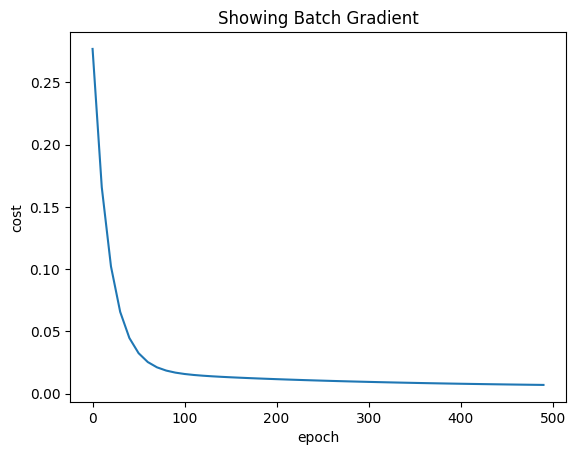

In [33]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list,cost_list)
plt.title("Showing Batch Gradient")

In [20]:
def predict(area,bedrooms,w,b):
    scaled_X = sx.transform([[area, bedrooms]])[0]
    # here w1 = w[0] , w2 = w[1], w3 = w[2] and bias is b
    # equation for price is w1*area + w2*bedrooms + w3*age + bias
    # scaled_X[0] is area
    # scaled_X[1] is bedrooms
    # scaled_X[2] is age
    scaled_price = w[0] * scaled_X[0] + w[1] * scaled_X[1] + b
    # once we get price prediction we need to to rescal it back to original value
    # also since it returns 2D array, to get single value we need to do value[0][0]
    return sy.inverse_transform([[scaled_price]])[0][0]

predict(2600,4,w,b)

128.45484403267596

In [21]:
predict(1000,2,w,b)

30.253094462442355

In [23]:
predict(2200,3,w,b)

92.52111776810878

## Implement Stochastic Gradient Descent
- Stochastic GD will use randomly picked single training sample to calculate error and using this error we backpropage to adjust weights

In [24]:
# we will use random libary to pick random training sample.
# randit gives random number between two numbers specified in the argument
import random
random.randint(0,6)

4

In [28]:
def stochastic_gradient_descent(X, y_true, epochs, learning_rate = 0.01):
 
    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 3 (area, bedroom and age)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0]
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):    
        random_index = random.randint(0,total_samples-1) # random index from total samples
        sample_x = X[random_index]
        sample_y = y_true[random_index]
        
        y_predicted = np.dot(w, sample_x.T) + b
    
        w_grad = -(2/total_samples)*(sample_x.T.dot(sample_y-y_predicted))
        b_grad = -(2/total_samples)*(sample_y-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.square(sample_y-y_predicted)
        
        if i%100==0: # at every 100th iteration record the cost and epoch value
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w_sgd, b_sgd, cost_sgd, cost_list_sgd, epoch_list_sgd = stochastic_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),10000)
print("Weights(w1,w2):", w_sgd)
print("Bias:",b_sgd)
print("Final Cost:", cost_sgd)


Weights(w1,w2): [0.70940574 0.6760764 ]
Bias: -0.2282569449349945
Final Cost: 0.0002556267665907664


In [34]:
w,b,cost # Belonging to Batch Gradient

(array([0.70712464, 0.67456527]), -0.23034857438407427, 0.0068641890429808105)

Text(0.5, 1.0, 'Showing SGD')

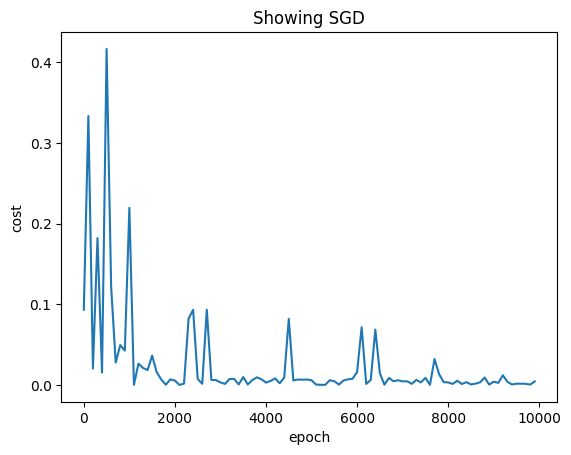

In [31]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list_sgd,cost_list_sgd)
plt.title("Showing SGD")

In [35]:
predict(1800,3,w_sgd, b_sgd)

79.84452983363786

In [39]:
predict(1440,3,w_sgd, b_sgd)

67.95586808639591

In [37]:
df.head()

,area,bedrooms,price
0,1056,2,39.07
1,2600,4,120.00
2,1440,3,62.00
3,1521,3,75.00
4,1200,2,51.00
